# Telco Customer Churn Prediction

### Import libraries

In [1]:
# Data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
import missingno as msno

# Modelling
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from imblearn import FunctionSampler
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn import set_config
set_config(display='diagram')

from time import time

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Data Analysis

In [2]:
data = pd.read_excel('data/Telco_customer_churn.xlsx')

In [3]:
df = data.copy()
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


### Summary

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [5]:
df.describe()

,Count,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Churn Value,Churn Score,CLTV
count,7043.0,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.0,93521.964646,36.282441,-119.798880,32.371149,64.761692,0.265370,58.699418,4400.295755
std,0.0,1865.794555,2.455723,2.157889,24.559481,30.090047,0.441561,21.525131,1183.057152
min,1.0,90001.000000,32.555828,-124.301372,0.000000,18.250000,0.000000,5.000000,2003.000000
25%,1.0,92102.000000,34.030915,-121.815412,9.000000,35.500000,0.000000,40.000000,3469.000000
50%,1.0,93552.000000,36.391777,-119.730885,29.000000,70.350000,0.000000,61.000000,4527.000000
75%,1.0,95351.000000,38.224869,-118.043237,55.000000,89.850000,1.000000,75.000000,5380.500000
max,1.0,96161.000000,41.962127,-114.192901,72.000000,118.750000,1.000000,100.000000,6500.000000


In [6]:
df.select_dtypes(np.object).describe().transpose()

,count,unique,top,freq
CustomerID,7043,7043,3668-QPYBK,1
Country,7043,1,United States,7043
State,7043,1,California,7043
City,7043,1129,Los Angeles,305
Lat Long,7043,1652,"33.964131, -118.272783",5
Gender,7043,2,Male,3555
Senior Citizen,7043,2,No,5901
Partner,7043,2,No,3641
Dependents,7043,2,No,5416
Phone Service,7043,2,Yes,6361


In [7]:
df.isnull().sum()

CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges           0
Churn Label             0
Churn Value             0
Churn Score             0
CLTV                    0
Churn Reason         5174
dtype: int64

### Missing Data

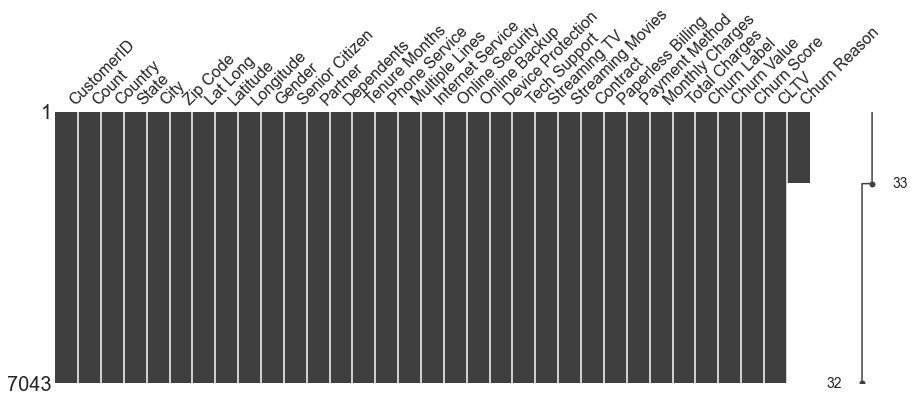

In [8]:
msno.matrix(df, figsize=(15,5))
plt.show()

### Unique Values

In [9]:
for column in df.select_dtypes(np.object).columns:
    num_values = len(df[column].unique())
    unique_values = df[column].unique()
    if num_values <= 15:
        print(f'{column:<17} ----- {num_values:<5} ----- {unique_values}') # <, >, or ^ symbols to specify left align, right align, or centering, respectively
    else:
        print(f'{column:<17} ----- {num_values:<5}')

CustomerID        ----- 7043 
Country           ----- 1     ----- ['United States']
State             ----- 1     ----- ['California']
City              ----- 1129 
Lat Long          ----- 1652 
Gender            ----- 2     ----- ['Male' 'Female']
Senior Citizen    ----- 2     ----- ['No' 'Yes']
Partner           ----- 2     ----- ['No' 'Yes']
Dependents        ----- 2     ----- ['No' 'Yes']
Phone Service     ----- 2     ----- ['Yes' 'No']
Multiple Lines    ----- 3     ----- ['No' 'Yes' 'No phone service']
Internet Service  ----- 3     ----- ['DSL' 'Fiber optic' 'No']
Online Security   ----- 3     ----- ['Yes' 'No' 'No internet service']
Online Backup     ----- 3     ----- ['Yes' 'No' 'No internet service']
Device Protection ----- 3     ----- ['No' 'Yes' 'No internet service']
Tech Support      ----- 3     ----- ['No' 'Yes' 'No internet service']
Streaming TV      ----- 3     ----- ['No' 'Yes' 'No internet service']
Streaming Movies  ----- 3     ----- ['No' 'Yes' 'No internet service'

**COMMENTS:**
- `CustomerID` is different for evey user, so it is irrelevant for classification, and will be dropped.
- `Count` has a single value for every example, so will be dropped.
- `Country` has a single value for every example, so will be dropped.
- `State` has a single value for every example, so will be dropped.
- `Lat Long` is irrelevant because there are separate columns for latitutde and longitude, so will be dropped.
- `Churn Label` is directly related to `Churn Value`, so will be dropped.
- `Churn Reason` is information given by the customer after they left the company, so it doesn't have predictibe ability, and will be dropped.


- `Total Charges` is of type `object`, but in fact it should be `np.number`, and will be converted.

### Class Distributions

In [10]:
def get_class_counts(df, feature):
    '''
    Function that returns the number of examples in each class
    '''
    classes = df[feature].unique()
    class_counts = dict()
    
    for c in classes:
        counts = df[df[feature] == c].shape[0]
        class_counts.update({c: counts})
    
    return class_counts

def get_class_proportions(df, feature):
    '''
    Function that returns the ratio of examples in each class (confirmed and false positive)
    '''
    class_counts = get_class_counts(df, feature)
    
    classes = df[feature].unique()
    total_examples = df[feature].shape[0]
    class_ratios = dict()
    
    for c in classes:
        ratio = np.round(df[df[feature] == c].shape[0] / total_examples, 4)*100
        class_ratios.update({c: ratio})
    
    return class_ratios

class_counts = get_class_counts(df=df, feature='Churn Value')
class_ratios = get_class_proportions(df=df, feature='Churn Value')

print(f'Data set class counts: {class_counts}')
print(f'Data set class ratios: {class_ratios}')

Data set class counts: {1: 1869, 0: 5174}
Data set class ratios: {1: 26.540000000000003, 0: 73.46000000000001}


## Preprocessing

In [11]:
def drop_and_convert(df):
    #df = df.copy()
    
    df = df.drop(['CustomerID',
                  'Count',
                  'Country',
                  'State',
                  'City',
                  'Lat Long',
                  'Churn Label',
                  'Churn Reason'
                 ], axis=1)
    
    df['Total Charges'] = pd.to_numeric(df['Total Charges'],
                         errors='coerce' # If 'coerce', then invalid parsing will be set as NaN
                        )
    
    df.loc[(df['Total Charges'].isna()), 'Total Charges'] = 0
    
    return df

**COMMENT:** Some examples have an empty string `" "` as value for `Total Charges`. These are missing values, and will be treated as such.

**COMMENT:** As expected, there are missing values in `Total Charges`, 11 in total, and will be imputed.

Can be seen that for those that don't have a value for `Total Charge`, for the column `Tenure Months` have a value of zero, meaning that they have just subscribed to the service so they haven't been charged yet. Also, these clients all have `Churn Value` set to `0` because they have just signed up.

The values `Total Charges` that are missing will be set to `0`.

In [12]:
check_drop_and_convert = drop_and_convert(df)
check_drop_and_convert.head()

,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value,Churn Score,CLTV
0,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,No,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,86,3239
1,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,67,2701
2,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,...,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,1,86,5372
3,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,...,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1,84,5003
4,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,...,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,1,89,5340


In [13]:
check_drop_and_convert.dtypes

Zip Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges        float64
Churn Value            int64
Churn Score            int64
CLTV                   int64
dtype: object

In [14]:
check_drop_and_convert.isnull().sum()

Zip Code             0
Latitude             0
Longitude            0
Gender               0
Senior Citizen       0
Partner              0
Dependents           0
Tenure Months        0
Phone Service        0
Multiple Lines       0
Internet Service     0
Online Security      0
Online Backup        0
Device Protection    0
Tech Support         0
Streaming TV         0
Streaming Movies     0
Contract             0
Paperless Billing    0
Payment Method       0
Monthly Charges      0
Total Charges        0
Churn Value          0
Churn Score          0
CLTV                 0
dtype: int64

**NOTE:** It may seem that converting the categorial data to numerical is a reasonable thing to do. But this is wrong. Here's why. Let's take the feature `Payment_Method` which has the following options:
1. `Mailed_Check`,
2. `Electronic_Check`,
3. `Bank_Transfer`,
4. `Credit_Card`.

If we converted these categories to numbers 1, 2, 3, and 4, and treated them like numerical data, then we would assume that 4, which means `Credit_Card`, is more similar to 3, which means `Bank_Transfer`, than it is to 1 or 2, which are other forms of payment. That means the `XGBoost` trees would be more likely to cluster the people with 3s and 4s together, than the people with 4s and 1s together.

**ANOTHER NOTE:** If we treat `Payment_Method` like categorical data, then we treat each value as a separate category that is no more or less similar to any of the other category. This is done with the technique called **one-hot encoding**. There are many different ways to do this in Python, but the following are the most popular: `ColumnTransformer()` (from `scikit-learn`), and `get_dummies()` (from `pandas`), and both methods have pros and cons.

`ColumnTransformer()` has a feature where it creates a persistent funcition that can validate data that you get in the future. The `ColumnTransformer()` can remember the options of the categorical feature, and when the `XGBoost` model (or any other model) is deployed in production it can recongize if someone records incorrect data point, and can throw an error, or handle the situation in a different way. The con of `ColumnTransformer()` is that it converts all data to an array, and looses the colun names, which might make it harder to verify the results.

On the other hand, `get_dummies()` leaves the data in a dataframe and retains the column names, making it much easier to verify that it worked the way that it was intended. However, it doesn't have the behaviour as `ColumnTransformer()` has.

In [15]:
drop_convert_features = ['CustomerID',
                         'Count',
                         'Country',
                         'State',
                         'City',
                         'Lat Long',
                         'Churn Label',
                         'Churn Reason',
                         'Total Charges'
                        ]
drop_convert_transformer = FunctionTransformer(drop_and_convert)

categorical_features = ['Gender',
                        'Senior Citizen',
                        'Partner',
                        'Dependents',
                        'Phone Service',
                        'Multiple Lines',
                        'Internet Service',
                        'Online Security',
                        'Online Backup',
                        'Device Protection',
                        'Tech Support',
                        'Streaming TV',
                        'Streaming Movies',
                        'Contract',
                        'Paperless Billing',
                        'Payment Method'
]
categorical_transformer = OneHotEncoder(sparse = False)

preprocessor = ColumnTransformer([
    ('drop-convert', drop_convert_transformer, drop_convert_features),
    ('1hot', categorical_transformer, categorical_features)
], remainder='passthrough', n_jobs=-1)

preprocessor

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('drop-convert',
                                 FunctionTransformer(func=<function drop_and_convert at 0x000001DB721E0D30>),
                                 ['CustomerID', 'Count', 'Country', 'State',
                                  'City', 'Lat Long', 'Churn Label',
                                  'Churn Reason', 'Total Charges']),
                                ('1hot', OneHotEncoder(sparse=False),
                                 ['Gender', 'Senior Citizen', 'Partner',
                                  'Dependents', 'Phone Service',
                                  'Multiple Lines', 'Internet Service',
                                  'Online Security', 'Online Backup',
                                  'Device Protection', 'Tech Support',
                                  'Streaming TV', 'Streaming Movies',
                                  'Contract', 'Paperless Billing',
                                  'Payment Method'])])

In [16]:
check_preprocessor = pd.DataFrame(data=preprocessor.fit_transform(df))
check_preprocessor

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,108.15,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,90003.0,33.964131,-118.272783,2.0,53.85,1.0,86.0,3239.0
1,151.65,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,90005.0,34.059281,-118.307420,2.0,70.70,1.0,67.0,2701.0
2,820.50,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,90006.0,34.048013,-118.293953,8.0,99.65,1.0,86.0,5372.0
3,3046.05,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,90010.0,34.062125,-118.315709,28.0,104.80,1.0,84.0,5003.0
4,5036.30,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,90015.0,34.039224,-118.266293,49.0,103.70,1.0,89.0,5340.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1419.40,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,92285.0,34.341737,-116.539416,72.0,21.15,0.0,45.0,5306.0
7039,1990.50,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,92301.0,34.667815,-117.536183,24.0,84.80,0.0,59.0,2140.0
7040,7362.90,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,92304.0,34.559882,-115.637164,72.0,103.20,0.0,71.0,5560.0
7041,346.45,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,92305.0,34.167800,-116.864330,11.0,29.60,0.0,59.0,2793.0


## Split Data into Features and Target

In [17]:
X = df.drop('Churn Value', axis=1).copy(deep=True)
y = df['Churn Value'].copy(deep=True)

**COMMENT:** 1 = the customer left the company this quarter. 0 = the customer remained with the company.

## Split Data into Train and Test Sets

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0, stratify=y)

In [19]:
X_train.shape, X_test.shape

((5986, 32), (1057, 32))

### SMOTE

SMOTE must be applied only on the training set, and not on the validation set or the test set. Thus, the `pipeline` class from `imblearn` must be used because it takes care of this.

SMOTE performs better when it is combined with under-sampling the majority class.

All intermediate steps of the chain should be estimators that implement `fit` and `transform` or `fit_resample`.

In [20]:
def cross_validate_model(clf, X_train, y_train):
    scores = cross_validate(clf, X_train, y_train, scoring=['f1', 'roc_auc'], cv=10)
    f1_mean = np.nanmean(scores['test_f1'])
    f1_std = np.nanstd(scores['test_f1'])

    auc_mean = np.nanmean(scores['test_roc_auc'])
    auc_std = np.nanstd(scores['test_roc_auc'])

    print(f'F1={f1_mean:.4f} (+/- {f1_std:.4f})')
    print(f'AUC={auc_mean:.4f} (+/- {auc_std:.4f})')
    
    return scores

def plot_confusion_matrix(clf, X_train, y_train):
    cm = confusion_matrix(y_train, clf.predict(X_train), labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    plt.show()

## `scikit-learn`'s Gradient Boosting

In [21]:
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

In [22]:
gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('over-sampling', SMOTE()),
    ('under-sampling', RandomUnderSampler()),
    ('gradient-boosting', gb_clf)
])
gb_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('drop-convert',
                                                  FunctionTransformer(func=<function drop_and_convert at 0x000001DB721E0D30>),
                                                  ['CustomerID', 'Count',
                                                   'Country', 'State', 'City',
                                                   'Lat Long', 'Churn Label',
                                                   'Churn Reason',
                                                   'Total Charges']),
                                                 ('1hot',
                                                  OneHotEncoder(sparse=False),
                                                  ['Gender', 'Senior Citizen',...
                                                   'Phone Service',
                                                   'Multiple Lines',
                                                   'Internet Service',
                                                   'Online Security',
                                                   'Online Backup',
                                                   'Device Protection',
                                                   'Tech Support',
                                                   'Streaming TV',
                                                   'Streaming Movies',
                                                   'Contract',
                                                   'Paperless Billing',
                                                   'Payment Method'])])),
                ('over-sampling', SMOTE()),
                ('under-sampling', RandomUnderSampler()),
                ('gradient-boosting',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=1,
                                            random_state=0))])

We can now use the pipeline created as a normal classifier where resampling will happen when calling `fit` and disabled when calling `decision_function`, `predict_proba`, or `predict`.

In [23]:
gb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('drop-convert',
                                                  FunctionTransformer(func=<function drop_and_convert at 0x000001DB721E0D30>),
                                                  ['CustomerID', 'Count',
                                                   'Country', 'State', 'City',
                                                   'Lat Long', 'Churn Label',
                                                   'Churn Reason',
                                                   'Total Charges']),
                                                 ('1hot',
                                                  OneHotEncoder(sparse=False),
                                                  ['Gender', 'Senior Citizen',...
                                                   'Phone Service',
                                                   'Multiple Lines',
                                                   'Internet Service',
                                                   'Online Security',
                                                   'Online Backup',
                                                   'Device Protection',
                                                   'Tech Support',
                                                   'Streaming TV',
                                                   'Streaming Movies',
                                                   'Contract',
                                                   'Paperless Billing',
                                                   'Payment Method'])])),
                ('over-sampling', SMOTE()),
                ('under-sampling', RandomUnderSampler()),
                ('gradient-boosting',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=1,
                                            random_state=0))])

In [24]:
gb_scores = cross_validate_model(clf=gb_pipeline, X_train=X_train, y_train=y_train)

F1=0.8653 (+/- 0.0138)
AUC=0.9817 (+/- 0.0025)


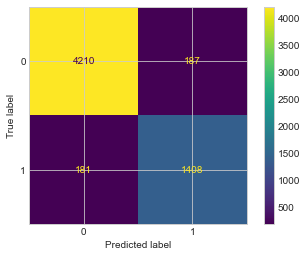

In [25]:
plot_confusion_matrix(clf=gb_pipeline, X_train=X_train, y_train=y_train)

## Optimization of Gradient Boosting

In [26]:
param_grid_gb = {'gradient-boosting__n_estimators': [50, 100, 150, 200, 250],
                 'gradient-boosting__learning_rate': np.arange(0.001, 1, 30),
                 'gradient-boosting__min_samples_split': [1, 2, 5, 10, 15, 100],
                 'gradient-boosting__min_samples_leaf': [1, 2, 5, 10],
                 'gradient-boosting__max_depth': [5, 8, 15, 25, 30]
                 }

t0 = time()
gb_opt = RandomizedSearchCV(
    estimator=gb_pipeline,
    param_distributions=param_grid_gb,
    n_iter=20,
    scoring='f1',
    n_jobs=-1,
    cv=10
).fit(X_train, y_train)
grid_searching_time_gb = time() - t0

print(f'Grid searching time: {grid_searching_time_gb:.4f} s')
print(f'{gb_opt.best_score_:.4f}')
print(f'{gb_opt.best_estimator_}')

Grid searching time: 558.3528 s
0.8658
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('drop-convert',
                                                  FunctionTransformer(func=<function drop_and_convert at 0x000001DB721E0D30>),
                                                  ['CustomerID', 'Count',
                                                   'Country', 'State', 'City',
                                                   'Lat Long', 'Churn Label',
                                                   'Churn Reason',
                                                   'Total Charges']),
                                                 ('1hot',
                                                  OneHotEncoder(sparse=False),
                                                  ['Gender', 'Senior Citizen',...
                                                   'Online Backup',
         

## Build XGBoost model

In [27]:
xgb_clf = xgb.XGBClassifier(eval_metric='logloss', subsample=0.9, colsample_bytree=0.5)
# Set eval_metrics to remove warning
# https://stackoverflow.com/questions/66097701/how-can-i-fix-this-warning-in-xgboost

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('over-sampling', SMOTE()),
    ('under-sampling', RandomUnderSampler()),
    ('XGBoost', xgb_clf)
])
xgb_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('drop-convert',
                                                  FunctionTransformer(func=<function drop_and_convert at 0x000001DB721E0D30>),
                                                  ['CustomerID', 'Count',
                                                   'Country', 'State', 'City',
                                                   'Lat Long', 'Churn Label',
                                                   'Churn Reason',
                                                   'Total Charges']),
                                                 ('1hot',
                                                  OneHotEncoder(sparse=False),
                                                  ['Gender', 'Senior Citizen',...
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None,
                               reg_alpha=None, reg_lambda=None,
                               scale_pos_weight=None, subsample=0.9,
                               tree_method=None, validate_parameters=None,
                               verbosity=None))])

In [28]:
xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('drop-convert',
                                                  FunctionTransformer(func=<function drop_and_convert at 0x000001DB721E0D30>),
                                                  ['CustomerID', 'Count',
                                                   'Country', 'State', 'City',
                                                   'Lat Long', 'Churn Label',
                                                   'Churn Reason',
                                                   'Total Charges']),
                                                 ('1hot',
                                                  OneHotEncoder(sparse=False),
                                                  ['Gender', 'Senior Citizen',...
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=0.9,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

In [29]:
xgb_scores = cross_validate_model(clf=xgb_pipeline, X_train=X_train, y_train=y_train)

F1=0.8583 (+/- 0.0215)
AUC=0.9808 (+/- 0.0035)


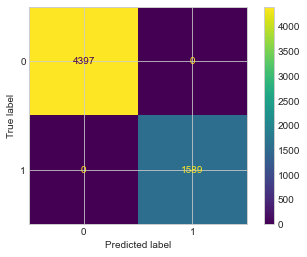

In [30]:
plot_confusion_matrix(clf=xgb_pipeline, X_train=X_train, y_train=y_train)

**NOTE:** We are doing much better job at classifying people that left the company, but this is at the expense of not being able to correctly classify as many people that didn't leave the company.

**NOTE (StatQuest INTERPRETATION):** When people leave the company, they reduce the revenue of the company as well. It would seem more reasonable to catch those people before they leave, and try to manipulate them to continue to use the services of the company.

## Hyperparameter Optimization of XGBoost model

**NOTE:** When the data is imbalanced, in the `XGBoost` manual they suggest we:
- balance the data with the hyper-parameter `scale_pos_weight`,
- use $F_{1}$ score as metric for evaluation.

**ANOTHER NOTE:** In order to speedup the cross-validation, and to further prevent overfitting, we are only using random subset of the data (90% in this example), and are only using random subset of the features (50% in this example).

In [31]:
param_grid_xgb = {
    'XGBoost__eta': [0.01, 0.015, 0.025, 0.05, 0.1],
    'XGBoost__gamma': [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'XGBoost__max_depth': [3, 5, 7, 9, 12, 15, 17, 25],
    'XGBoost__min_child_weight': [1, 3, 5, 7],
    'XGBoost__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'XGBoost__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'XGBoost__lambda': [0.01, 0.1, 1.0],
    'XGBoost__alpha': [0, 0.1, 0.5, 1.0],
    'XGBoost__scale_pos_weight': [1, 3, 5] #XGBoost recommends: sum(negative instances) / sum(positive instances)
}

t0 = time()
xgbc_opt = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_grid_xgb,
    n_iter=20,
    scoring='f1',
    n_jobs=-1,
    cv=10
).fit(X_train, y_train)
grid_searching_time_xgb = time() - t0

print(f'Grid searching time: {grid_searching_time_xgb:.4f} s')
print(f'{xgbc_opt.best_score_:.4f}')
print(f'{xgbc_opt.best_estimator_}')

Grid searching time: 155.6715 s
0.8663
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('drop-convert',
                                                  FunctionTransformer(func=<function drop_and_convert at 0x000001DB721E0D30>),
                                                  ['CustomerID', 'Count',
                                                   'Country', 'State', 'City',
                                                   'Lat Long', 'Churn Label',
                                                   'Churn Reason',
                                                   'Total Charges']),
                                                 ('1hot',
                                                  OneHotEncoder(sparse=False),
                                                  ['Gender', 'Senior Citizen',...
                               eta=0.015, eval_metric='logloss', gamma=0.05,


## Build LightGBM model

LightGBM can use categorical features directly (without one-hot encoding). In this project one-hot encoding will be used.

In [32]:
lgbm_clf = LGBMClassifier(random_state=0)

lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('over-sampling', SMOTE()),
    ('under-sampling', RandomUnderSampler()),
    ('lgbm', lgbm_clf)
])
lgbm_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('drop-convert',
                                                  FunctionTransformer(func=<function drop_and_convert at 0x000001DB721E0D30>),
                                                  ['CustomerID', 'Count',
                                                   'Country', 'State', 'City',
                                                   'Lat Long', 'Churn Label',
                                                   'Churn Reason',
                                                   'Total Charges']),
                                                 ('1hot',
                                                  OneHotEncoder(sparse=False),
                                                  ['Gender', 'Senior Citizen',
                                                   'Partner', 'Dependents',
                                                   'Phone Service',
                                                   'Multiple Lines',
                                                   'Internet Service',
                                                   'Online Security',
                                                   'Online Backup',
                                                   'Device Protection',
                                                   'Tech Support',
                                                   'Streaming TV',
                                                   'Streaming Movies',
                                                   'Contract',
                                                   'Paperless Billing',
                                                   'Payment Method'])])),
                ('over-sampling', SMOTE()),
                ('under-sampling', RandomUnderSampler()),
                ('lgbm', LGBMClassifier(random_state=0))])

In [33]:
lgbm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('drop-convert',
                                                  FunctionTransformer(func=<function drop_and_convert at 0x000001DB721E0D30>),
                                                  ['CustomerID', 'Count',
                                                   'Country', 'State', 'City',
                                                   'Lat Long', 'Churn Label',
                                                   'Churn Reason',
                                                   'Total Charges']),
                                                 ('1hot',
                                                  OneHotEncoder(sparse=False),
                                                  ['Gender', 'Senior Citizen',
                                                   'Partner', 'Dependents',
                                                   'Phone Service',
                                                   'Multiple Lines',
                                                   'Internet Service',
                                                   'Online Security',
                                                   'Online Backup',
                                                   'Device Protection',
                                                   'Tech Support',
                                                   'Streaming TV',
                                                   'Streaming Movies',
                                                   'Contract',
                                                   'Paperless Billing',
                                                   'Payment Method'])])),
                ('over-sampling', SMOTE()),
                ('under-sampling', RandomUnderSampler()),
                ('lgbm', LGBMClassifier(random_state=0))])

In [34]:
lgbm_scores = cross_validate_model(clf=lgbm_pipeline, X_train=X_train, y_train=y_train)

F1=0.8576 (+/- 0.0189)
AUC=0.9812 (+/- 0.0028)


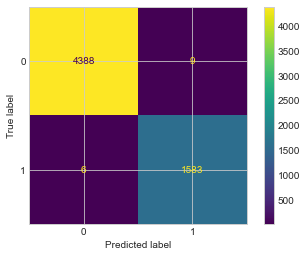

In [35]:
plot_confusion_matrix(clf=lgbm_pipeline, X_train=X_train, y_train=y_train)

## Optimization of LightGBM model

In [36]:
param_grid_lgbm = {
    'lgbm__num_leaves': [50, 60, 70, 80, 90, 100],
    'lgbm__min_data_in_leaf': [500, 600, 700, 800, 900, 1000],
    'lgbm__max_depth': [3, 5, 7, 9, 12, 15, 17, 20]
}

t0 = time()
lgbm_opt = RandomizedSearchCV(
    estimator=lgbm_pipeline,
    param_distributions=param_grid_lgbm,
    n_iter=20,
    scoring='f1',
    n_jobs=-1,
    cv=10
).fit(X_train, y_train)
grid_searching_time_lgbm = time() - t0

print(f'Grid searching time: {grid_searching_time_lgbm:.4f} s')
print(f'{lgbm_opt.best_score_:.4f}')
print(f'{lgbm_opt.best_estimator_}')

[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
Grid searching time: 50.1165 s
0.8741
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('drop-convert',
                                                  FunctionTransformer(func=<function drop_and_convert at 0x000001DB721E0D30>),
                                                  ['CustomerID', 'Count',
                                                   'Country', 'State', 'City',
                                                   'Lat Long', 'Churn Label',
                                                   'Churn Reason',
                                                   'Total Charges']),
                                                 ('1hot',
                                                  OneHotEncoder(sparse=False),
                                    

## Build CatBoost model

In [37]:
temp = X_train.drop(drop_convert_features, axis=1)
cat_features = list(temp.select_dtypes('object').columns)
cat_index = [temp.columns.get_loc(c) for c in temp.select_dtypes('object').columns]

In [38]:
catb_clf = CatBoostClassifier(eval_metric='F1', random_state=0, cat_features=cat_features, verbose=False)

catb_pipeline = Pipeline([
    ('drop-convert', FunctionSampler(drop_and_convert)),
    ('over-sampling', SMOTENC(categorical_features=cat_index)),
    ('under-sampling', RandomUnderSampler()),
    ('catboost', catb_clf)
])
catb_pipeline

Pipeline(steps=[('drop-convert',
                 FunctionSampler(func=<function drop_and_convert at 0x000001DB721E0D30>)),
                ('over-sampling',
                 SMOTENC(categorical_features=[3, 4, 5, 6, 8, 9, 10, 11, 12, 13,
                                               14, 15, 16, 17, 18, 19])),
                ('under-sampling', RandomUnderSampler()),
                ('catboost',
                 <catboost.core.CatBoostClassifier object at 0x000001DB72307F40>)])

In [39]:
#catb_pipeline.fit(X_train, y_train, catboost__cat_features=cat_features)

In [40]:
def catb_preprocessor(X, y):
    X = drop_and_convert(X)
    cat_features = list(X.select_dtypes('object').columns)
    cat_index = [X.columns.get_loc(c) for c in temp.select_dtypes('object').columns]
    
    X_res, y_res = SMOTENC(categorical_features=cat_index).fit_resample(X, y)
    X_res_up, y_res_up = RandomUnderSampler().fit_resample(X_res, y_res)
    
    return X_res_up, y_res_up

In [41]:
X_train_cat, y_train_cat = catb_preprocessor(X_train, y_train)

In [42]:
catb_clf.fit(X_train_cat, y_train_cat, cat_features=cat_features)

In [43]:
catb_scores = cross_validate_model(clf=catb_clf, X_train=X_train_cat, y_train=y_train_cat)

F1=0.9522 (+/- 0.0049)
AUC=0.9914 (+/- 0.0013)


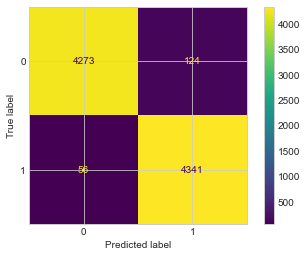

In [44]:
plot_confusion_matrix(clf=catb_clf, X_train=X_train_cat, y_train=y_train_cat)

## Optimization of CatBoost model

In [45]:
param_grid_catb = {
    'iterations': [100, 250, 500, 1000],
    'learning_rate': np.arange(0.001, 10, 30),
    'depth': [6, 7, 8, 9, 10],
    'l2_leaf_reg': np.arange(1, 100, 30)
}

t0 = time()
catb_opt = RandomizedSearchCV(
    estimator=catb_clf,
    param_distributions=param_grid_catb,
    n_iter=20,
    scoring='f1',
    n_jobs=-1,
    cv=10
).fit(X_train_cat, y_train_cat)
grid_searching_time_catb = time() - t0

print(f'Grid searching time: {grid_searching_time_catb:.4f} s')
print(f'{catb_opt.best_score_:.4f}')
print(f'{catb_opt.best_estimator_}')

Grid searching time: 2946.4131 s
0.9459


## Evaluating models

### Evaluation of models with default hyperparameters

Evaluation of model: Gradient Boosting
Accuracy score: 0.9290
Precision score: 0.8498
Recall score: 0.8893
F1 score: 0.8691
AUC score: 0.9843


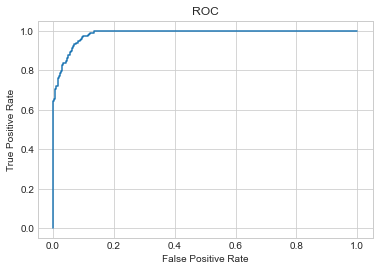




Evaluation of model: XGBoost
Accuracy score: 0.9272
Precision score: 0.8638
Recall score: 0.8607
F1 score: 0.8623
AUC score: 0.9833


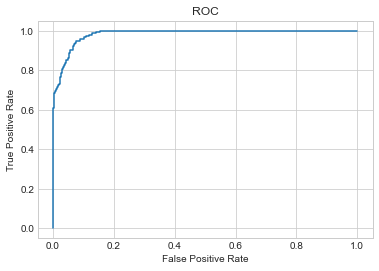




Evaluation of model: LightGBM
Accuracy score: 0.9338
Precision score: 0.8777
Recall score: 0.8714
F1 score: 0.8746
AUC score: 0.9852


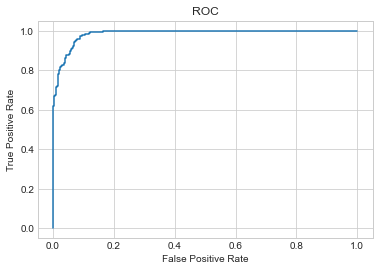




Evaluation of model: CatBoost
Accuracy score: 0.9300
Precision score: 0.8366
Recall score: 0.9143
F1 score: 0.8737
AUC score: 0.9846


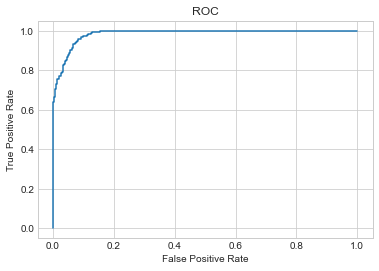

In [46]:
default_models = [
    gb_pipeline,
    xgb_pipeline,
    lgbm_pipeline,
    catb_clf
]

default_names = [
    'Gradient Boosting',
    'XGBoost',
    'LightGBM',
    'CatBoost'
]

X_test_cat = drop_and_convert(X_test)

Models = []
Accuracy_scores = []
Precision_scores = []
Recall_scores = []
F1_scores = []
AUC_scores = []

for model, name in zip(default_models, default_names):
    print('='*50)
    if name == 'CatBoost':
        y_pred = model.predict(X_test_cat)
    else:
        y_pred = model.predict(X_test)
    
    Accuracy_score = accuracy_score(y_test, y_pred)
    Precision_score = precision_score(y_test, y_pred)
    Recall_score = recall_score(y_test, y_pred)
    F1_score = f1_score(y_test, y_pred)
    if name == 'CatBoost':
        Roc_auc_score = roc_auc_score(y_test, model.predict_proba(X_test_cat)[:, 1])
    else:
        Roc_auc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    
    print(f'Evaluation of model: {name}')
    print(f'Accuracy score: {Accuracy_score:.4f}')
    print(f'Precision score: {Precision_score:.4f}')
    print(f'Recall score: {Recall_score:.4f}')
    print(f'F1 score: {F1_score:.4f}')
    print(f'AUC score: {Roc_auc_score:.4f}')
    
    if name == 'CatBoost':
        fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_cat)[:, 1])
    else:
        fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    
    plt.plot(fpr, tpr, label=f'{name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.show()
    
    Models.append(name)
    Accuracy_scores.append(Accuracy_score)
    Precision_scores.append(Precision_score)
    Recall_scores.append(Recall_score)
    F1_scores.append(F1_score)
    AUC_scores.append(Roc_auc_score)
    print('\n\n')

In [47]:
summary_default = pd.DataFrame({
    'Model': Models,
    'Accuracy Score': Accuracy_scores,
    'Precision Score': Precision_scores,
    'Recall Score': Recall_scores,
    'F1 Score': F1_scores,
    'AUC Score': AUC_scores
})
summary_default.sort_values('F1 Score', ascending=False)

,Model,Accuracy Score,Precision Score,Recall Score,F1 Score,AUC Score
2,LightGBM,0.933775,0.877698,0.871429,0.874552,0.985158
3,CatBoost,0.929991,0.836601,0.914286,0.873720,0.984574
0,Gradient Boosting,0.929044,0.849829,0.889286,0.869110,0.984303
1,XGBoost,0.927152,0.863799,0.860714,0.862254,0.983338


### Evaluation of models with optimized hyperparameters

Evaluation of model: Gradient Boosting
Accuracy score: 0.9290
Precision score: 0.8451
Recall score: 0.8964
F1 score: 0.8700
AUC score: 0.9802


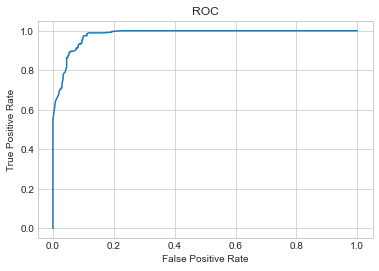




Evaluation of model: XGBoost
Accuracy score: 0.9319
Precision score: 0.8662
Recall score: 0.8786
F1 score: 0.8723
AUC score: 0.9816


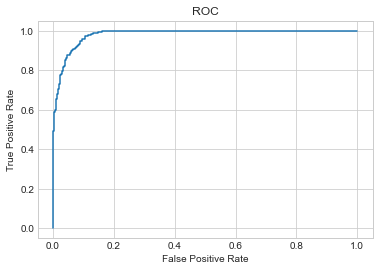




Evaluation of model: LightGBM
Accuracy score: 0.9272
Precision score: 0.8418
Recall score: 0.8929
F1 score: 0.8666
AUC score: 0.9849


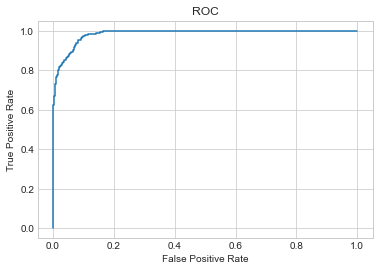




Evaluation of model: CatBoost
Accuracy score: 0.9272
Precision score: 0.8243
Recall score: 0.9214
F1 score: 0.8702
AUC score: 0.9832


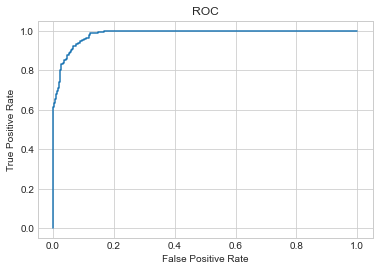

In [48]:
optimized_models = [
    gb_opt,
    xgbc_opt,
    lgbm_opt,
    catb_opt
]

optimized_names = [
    'Gradient Boosting - opt',
    'XGBoost - opt',
    'LightGBM - opt',
    'CatBoost - opt'
]

Models = []
Accuracy_scores = []
Precision_scores = []
Recall_scores = []
F1_scores = []
AUC_scores = []

for model, name in zip(optimized_models, default_names):
    print('='*50)
    if name == 'CatBoost':
        y_pred = model.predict(X_test_cat)
    else:
        y_pred = model.predict(X_test)
    
    Accuracy_score = accuracy_score(y_test, y_pred)
    Precision_score = precision_score(y_test, y_pred)
    Recall_score = recall_score(y_test, y_pred)
    F1_score = f1_score(y_test, y_pred)
    if name == 'CatBoost':
        Roc_auc_score = roc_auc_score(y_test, model.predict_proba(X_test_cat)[:, 1])
    else:
        Roc_auc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    
    print(f'Evaluation of model: {name}')
    print(f'Accuracy score: {Accuracy_score:.4f}')
    print(f'Precision score: {Precision_score:.4f}')
    print(f'Recall score: {Recall_score:.4f}')
    print(f'F1 score: {F1_score:.4f}')
    print(f'AUC score: {Roc_auc_score:.4f}')
    
    if name == 'CatBoost':
        fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_cat)[:, 1])
    else:
        fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    
    plt.plot(fpr, tpr, label=f'{name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.show()
    
    Models.append(name)
    Accuracy_scores.append(Accuracy_score)
    Precision_scores.append(Precision_score)
    Recall_scores.append(Recall_score)
    F1_scores.append(F1_score)
    AUC_scores.append(Roc_auc_score)
    print('\n\n')

In [49]:
summary_opt = pd.DataFrame({
    'Model': Models,
    'Accuracy Score': Accuracy_scores,
    'Precision Score': Precision_scores,
    'Recall Score': Recall_scores,
    'F1 Score': F1_scores,
    'AUC Score': AUC_scores
})
summary_opt.sort_values('F1 Score', ascending=False)

,Model,Accuracy Score,Precision Score,Recall Score,F1 Score,AUC Score
1,XGBoost,0.931883,0.866197,0.878571,0.872340,0.981596
3,CatBoost,0.927152,0.824281,0.921429,0.870152,0.983209
0,Gradient Boosting,0.929044,0.845118,0.896429,0.870017,0.980242
2,LightGBM,0.927152,0.841751,0.892857,0.866551,0.984924


The data set was downloaded from [here](https://community.ibm.com/accelerators/catalog/content/Telco-customer-churn) on 27 September 2021.

Descriptions of the features is [here](https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113) on 27 September 2021.

Project inspired by [video](https://www.youtube.com/watch?v=GrJP9FLV3FE&list=PLblh5JKOoLULU0irPgs1SnKO6wqVjKUsQ&index=5&ab_channel=StatQuestwithJoshStarmer) from StatQuest.

References:
- https://imbalanced-learn.org/stable/auto_examples/pipeline/plot_pipeline_classification.html#sphx-glr-auto-examples-pipeline-plot-pipeline-classification-py